# BE 521: Homework 6 Questions

## Spike Sorting
### Spring 2024

60 points + 6 EC

### Due: March 14th, 2024

Objective: To detect and cluster spikes.

In [275]:
!jupyter nbconvert --to html YuanchaoZhang_HW6.ipynb

[NbConvertApp] Converting notebook YuanchaoZhang_HW6.ipynb to html
[NbConvertApp] Writing 2624513 bytes to YuanchaoZhang_HW6.html


## Overview
In this homework, you will do some basic spike sorting using two different datasets. The first `I521_A0006_D001` is from a crayfish neuromuscular junction, a good model for human central nervous system synapses$^1$. Specifically, the data contains two simultaneous recordings: an extracellular recording from the third nerve (channel `nerve`) of a crayfish abdominal ganglion, which contains six spontaneously active motor neurons, and an intracellular recording from the superficial flexor muscle (channel `muscle`) innervated by this nerve. You will attempt to discern relationships between the classes of spike waveforms you extract from the motor nerve trace and elicited potentials seen in the muscle fiber recording.
Then, you will revisit a human intracranial EEG recording `I521_A0006_D002` and use some of the techniques you've learned in class to build a more automated spike sorter.
Note: While spikes may have positive and negative deflections, we will only focus on positive spikes on this homework for simplicity.


$^1$ The sampling rate of this data is 2000 Hz, which is adequate for this homework's instructional purposes but usually inadequate for real spike sorting, which often uses sampling frequencies on the order of 20 kHz.

In [276]:
#Set up the notebook environment
!pip install git+https://github.com/ieeg-portal/ieegpy.git # Install ieegpy toolbox directly from github
from ieeg.auth import Session
import matplotlib.pyplot as plt
import numpy as np

from scipy.signal import ellip, lfilter, filtfilt, find_peaks
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

  Cloning https://github.com/ieeg-portal/ieegpy.git to /tmp/pip-req-build-9y2g8nir
  Running command git clone --filter=blob:none --quiet https://github.com/ieeg-portal/ieegpy.git /tmp/pip-req-build-9y2g8nir
  Resolved https://github.com/ieeg-portal/ieegpy.git to commit 080bfa42a8503380ef164b5e7b116613f75073bb
  Preparing metadata (setup.py) ... done


## 1. Spike Detection and Clustering (38 pts)

In this section, you will explore some basic filtering and spike thresholding to ultimately compare spike clusters you pick out by eye to those selected by an automated algorithm.

In [277]:
with open('/content/Yua_ieeglogin.bin', 'r') as f:
  session = Session('Yuanchz1118', f.read())

# get the specified dataset from IEEG
dataset1 = session.open_dataset('I521_A0006_D001')

dataset1_label = dataset1.get_channel_labels()
print(dataset1_label, "\n")
dataset1_index = dataset1.get_channel_indices(dataset1_label)
print(dataset1_index, "\n")

### Nerve Data: Index[1]
nerve_timeseries = dataset1.get_time_series_details(dataset1_label[1])
print(nerve_timeseries, "\n")
nerve_sample_rate = int(nerve_timeseries.sample_rate)
print("Smpling rate of the nerve:",nerve_sample_rate, "Hz", "\n")

nerve_start_time = nerve_timeseries.start_time
nerve_end_time = nerve_timeseries.end_time

nerve_duration = nerve_timeseries.duration
print("Duration of the nerve:", nerve_duration, "us \n")

### Extract Nerve Data from an extracellular recording from the third nerve (channel nerve)
nerve_data = dataset1.get_data(nerve_start_time,nerve_end_time - nerve_start_time + 1,[1]) * 10**-3 # Convert unit from μV to mV
print("The total number of the nerve units:", len(nerve_data), "\n")
print("Nerve_Data(mV):\n", nerve_data)

['muscle', 'nerve'] 

[0, 1] 

None(nerve) spans 4479500.0 usec, range [-500000-358000] in 8960 samples. Starts @1 uUTC, ends @4479501 uUTC with sample rate 2000.0 Hz and voltage conv factor 1.0 

Smpling rate of the nerve: 2000 Hz 

Duration of the nerve: 4479500.0 us 

The total number of the nerve units: 8960 

Nerve_Data(mV):
 [[-1.]
 [-3.]
 [ 0.]
 ...
 [ 3.]
 [ 0.]
 [ 0.]]


### 1
You can assume that the nerve samples have already been low-pass filtered. Here, you will high-pass filter in order to remove signals like slow local field potentials and 60 Hz power line noise. Create a 4th order *elliptic filter* with 0.1 dB of ripple in the passband, a stopband 40 dB lower than the peak value in the passband, and a passband edge frequency of 300 Hz (see [`scipy.signal.ellip`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.ellip.html#scipy.signal.ellip) and make sure you give the edge frequency in the correct normalized form). The statement to create this filter (defined by the filter coefficients `b` and `a`) should look something like

```python
from scipy.signal import ellip

(b, a) = ellip(N, rp, rs, Wn, btype='highpass')
```

Clearly specify the denominator and numerator coefficients obtained for your filter function. (2pts)

In [278]:
# My code here
sample_rate = 2000
N = 4
rp = 0.1
rs = 40
Wn = 2 * 300 / sample_rate
(b,a) = ellip(N, rp, rs, Wn,btype = 'highpass')

### Denominator (a)
print("Denominator Coefficients(a):", a)
### Numerator (b)
print("Numerator Coefficients(b):", b)

Denominator Coefficients(a): [ 1.         -1.74317755  1.61666596 -0.65593013  0.14304101]
Numerator Coefficients(b): [ 0.34204923 -1.27403905  1.86758564 -1.27403905  0.34204923]


**My Answer Here:**

**Denominator Coefficients(a)** for my filter function: **[ 1.         -1.74317755  1.61666596 -0.65593013  0.14304101]**

**Numerator Coefficients(b)** for my filter function: **[ 0.34204923 -1.27403905  1.86758564 -1.27403905  0.34204923]**

### 2
Using the [`scipy.signal.lfilter`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html#scipy.signal.lfilter) function and [`scipy.signal.filtfilt`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html#scipy.signal.filtfilt) function, obtain two different filtered outputs of the nerve signal.

In [279]:
# My code here
lfilter_output = lfilter(b, a, nerve_data, axis = 0)
print("First Output of the nerve signal with lfilter (mV):\n", lfilter_output, "\n")

filtfilt_output = filtfilt(b, a, nerve_data, axis = 0, padlen = 0)
print("First Output of the nerve signal with filtfilt (mV):\n", filtfilt_output)

First Output of the nerve signal with lfilter (mV):
 [[-0.34204923]
 [-0.34836116]
 [ 1.90025549]
 ...
 [ 3.51530117]
 [-2.05151584]
 [-1.81178199]] 

First Output of the nerve signal with filtfilt (mV):
 [[ 0.12710028]
 [-2.21389461]
 [ 0.51254434]
 ...
 [ 1.96649522]
 [-0.1001186 ]
 [-0.01811782]]


#### 2a
In a 2x1 subplot, plot the first 50 ms of the unfiltered nerve signal in the top subplot; in the bottom subplot, plot the `lfilter` output in blue and the `filtfilt` output in red. Use a potential range (y-axis) of -20 to 50 millivolts. (4 pts)

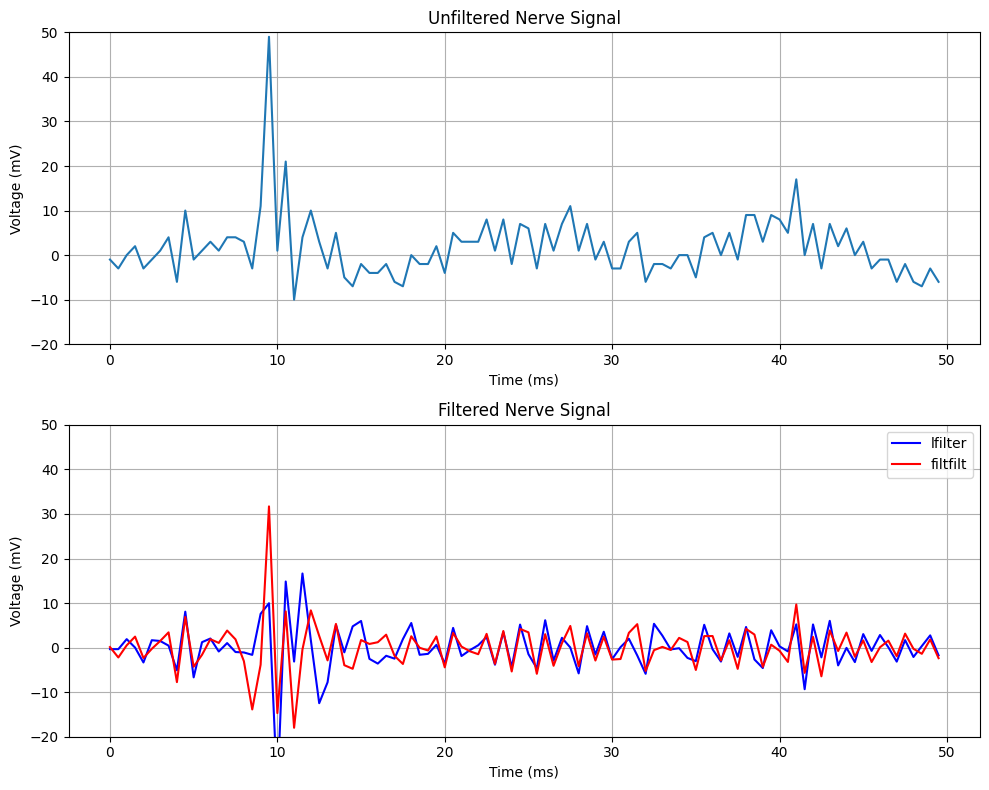

In [280]:
# Your code here
import numpy as np
import matplotlib.pyplot as plt

nerve_TimeRange1 = np.arange(0, 50, 1000/sample_rate)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

End_Unfiltered_Nerve1 = int(0.05*sample_rate)

ax1.plot(nerve_TimeRange1, nerve_data[0:End_Unfiltered_Nerve1])
ax1.set_ylim(-20, 50)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Voltage (mV)')
ax1.set_title('Unfiltered Nerve Signal')
ax1.grid(True)

ax2.plot(nerve_TimeRange1, lfilter_output[0:End_Unfiltered_Nerve1], label='lfilter', color='blue')
ax2.plot(nerve_TimeRange1, filtfilt_output[0:End_Unfiltered_Nerve1], label='filtfilt', color='red')
ax2.set_ylim(-20, 50)
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Voltage (mV)')
ax2.set_title('Filtered Nerve Signal')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

#### 2b
How is the unfiltered signal different from the filtered signal? What is different about the two filtered (red and blue) signals? (2 pts)

**My Answer Here:**

It's hard for us to directly observe and approximate the regularities of spikes' distribution via Unfiltered Nerve Signal; On the contrary, **we can more directly estimate the overall distribution of spikes via filtered signal.**

According to my observation of previous filtered signals' plots after 15ms, while both of two filtered signals show the relatively stable distribution of spikes with slighter fluctuations compared to unfiltered signals, **"filtfilt" guarantees that the filtered signal accurately reflects the temporal characteristics of the original nerve signal while preserving the temporal relationship between spikes.**



#### 2c
Briefly explain the mathematical difference between the two filtering methods, and why one method might be more advantageous than the other in the context of spike detection? (5 pts)

**My Answer Here:**

**"filtfilt" is more advantageous than "lfilter" in the context of spike detection.**

**[1]** **The "lfilter" function implements a linear filtering process known as Finite Impulse Response (FIR) filtering.** In this method, the filter operates causally, meaning it only considers past and present values of the signal during computation. The filtering operation is performed in a forward direction using a difference equation, where each output sample depends on the current input sample and past input and output samples. However, since it's a causal filter, it introduces a phase delay in the filtered output relative to the input signal. This delay can affect the temporal alignment of features in the signal, potentially distorting time-sensitive information such as the precise timing of neural spikes.**"lfilter" may generate phase distortions that cause spikes to become misaligned or change their temporal features**, which makes it less appropriate for applications involving spike identification where accurate temporal information is essential.

**[2]** **On the other hand, the "filtfilt" function implements a zero-phase digital filtering algorithm.** Unlike "lfilter", which operates causally, filtfilt applies the filter coefficients in both forward and backward directions. This bidirectional filtering ensures that phase distortions introduced by the filter are effectively cancelled out, resulting in a filtered output that closely aligns with the original signal in terms of phase. By mitigating phase distortions, filtfilt preserves the temporal relationships within the signal, making it particularly advantageous in applications where phase consistency is crucial, such as spike detection in neuroscience.
**Because "filtfilt" maintains the time link between spikes and ensures that the filtered signal faithfully captures the temporal properties of the original nerve signal, "filtfilt" is more advantageous than "lfilter" in the context of spike detection.**

### 3
Using a spike threshold of +30 mV, calculate the index and value of the peak voltage for each spike in the **filtered** nerve signal (select the best one). Use these values to plot the first 2.5 seconds of the nerve signal with a red dot above (e.g. 10 mV above) each spike. (Hint: Plot the entire length of the nerve signal with all the spikes marked but then restrict the x-axis using `plt.xlim()` to [0, 2.5] seconds.) (4 pts)


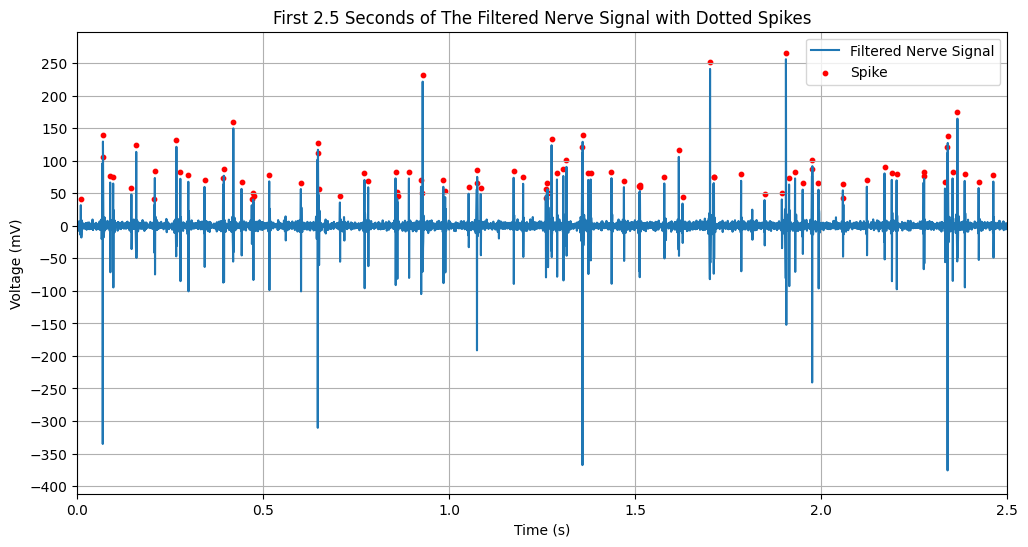

In [281]:
# My code here
def Locate_Spike(Data, Threshold):
  spike_indices_lst = []
  for i in range(1, len(Data) - 1):
    if Data[i] >= Threshold and Data[i] >= Data[i-1] and Data[i] >= Data[i+1]:
      spike_indices_lst.append(i)
  spike_indices_arr = np.array(spike_indices_lst)
  return spike_indices_arr

nerve_duration_sec = nerve_duration * 10**(-6)
Step1 = 1 / nerve_sample_rate
nerve_TimeRange2 = np.arange(0, nerve_duration_sec + Step1 , Step1)

Spike_Threshold = 30
spike_indices = Locate_Spike(filtfilt_output, Spike_Threshold)
spike_time = nerve_TimeRange2[spike_indices]
peak_voltage = filtfilt_output[spike_indices]

plt.figure(figsize=(12, 6))
plt.plot(nerve_TimeRange2, filtfilt_output, label='Filtered Nerve Signal')
### Red dots above (e.g. 10 mV above) each spike
plt.scatter(spike_time, peak_voltage + 10, color='red', s=10, label='Spike')
plt.yticks(np.arange(-400, 300, step = 50))
plt.grid(True)
plt.xlabel('Time (s)')
plt.xlim(0, 2.5)
plt.ylabel('Voltage (mV)')
# plt.ylim(-400, 300)
plt.title('First 2.5 Seconds of The Filtered Nerve Signal with Dotted Spikes')
plt.legend()
plt.show()

### 4

Under the assumption that different cells produce different action potentials with distinct peak amplitudes, decide how many cells you think were recorded (some number between 1 and 6). You may find it helpful to zoom in and pan on the plot you made in question 1.3. You may also find it useful to plot the sorted peak values to gain insight into where "plateaus" might be. (No need to include these preliminary plots in the report, though.) Use thresholds (which you will set manually/by eye) to separate the different spikes. Make a plot of the first 2.5 seconds similar to that in 1.3 except now color the spike dots of each group a different color (e.g., ``r, g, k, m``). (6 pts)

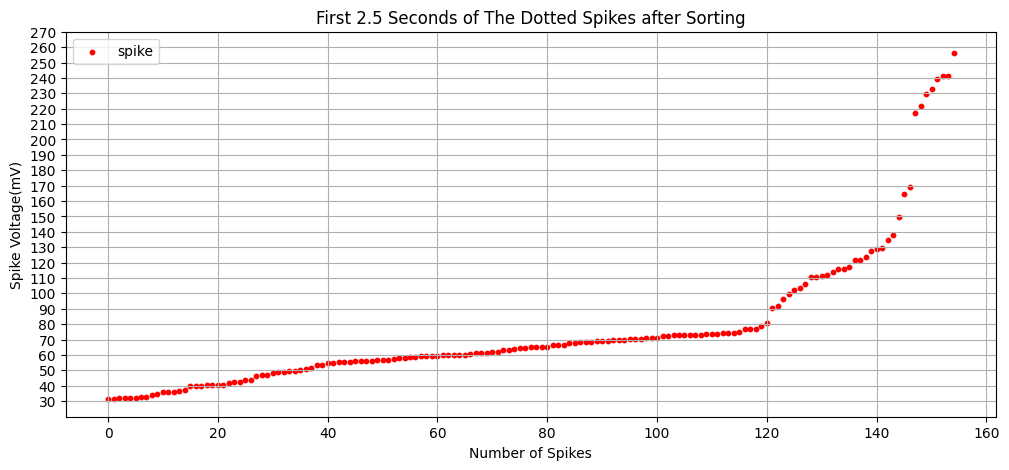

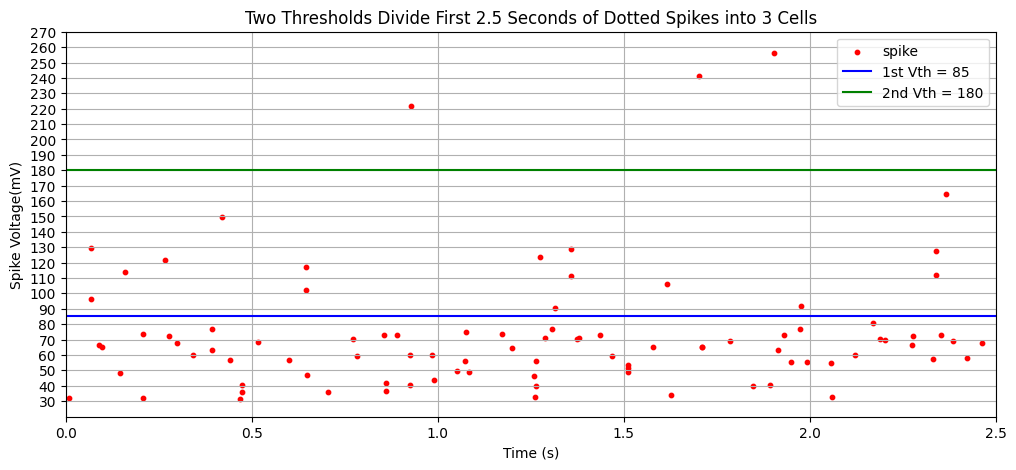

In [282]:
### Sort Peak Voltages from Lowest to Highest
sorted_peak_voltage = sorted(peak_voltage)
# print("\n\nSorted Peak Voltage:", sorted_peak_voltage, "\n\n")

### Replot First 2.5 Seconds of The Dotted Spikes after Sorting
### Such a updated plot with sorted spikes is used to distinguish thresholds of separating different spikes
plt.figure(figsize = (12,5))
plt.scatter(np.arange(0, peak_voltage.shape[0]), sorted_peak_voltage, color='red', s=10, label='spike')
plt.xlabel('Number of Spikes')
plt.ylabel('Spike Voltage(mV)')
plt.yticks(np.arange(30, 280, step = 10))
plt.title('First 2.5 Seconds of The Dotted Spikes after Sorting')
plt.legend()
plt.grid(True)
plt.show()
print("\n\n")

Cell_Nums = 3
Spike_Threshold1 = 85
Spike_Threshold2 = 180

### Extract First 2.5 Seconds of Dotted Spikes
plt.figure(figsize = (12,5))
plt.scatter(spike_time, peak_voltage, color='red', s=10, label='spike')
plt.xlabel('Time (s)')
plt.xlim(0, 2.5)
plt.ylabel('Spike Voltage(mV)')
plt.yticks(np.arange(30, 280, step = 10))
plt.axhline(Spike_Threshold1, color = 'blue', label = '1st Vth = 85')
plt.axhline(Spike_Threshold2, color = 'green', label = '2nd Vth = 180')
plt.title('Two Thresholds Divide First 2.5 Seconds of Dotted Spikes into 3 Cells')
plt.legend()
plt.grid(True)
plt.show()

**My Answer Here:**

According to my observation of First 2.5 Seconds of The Dotted Spikes after Sorting's plot: Under the assumption that different cells produce different action potentials with distinct peak amplitudes, I think **3 Cells** were recorded.

**Cell #1 (Red) : Approximate Range from 30 to 85 (Number of spikes in Cell#1 = 121)**

**Cell #2 (Green) : Approximate Range from 85 to 180 (Number of spikes in Cell#2 = 26)**

**Cell #3 (Purple) : Approximate Range from 180 to 260 (Number of spikes in Cell#3 = 8)**

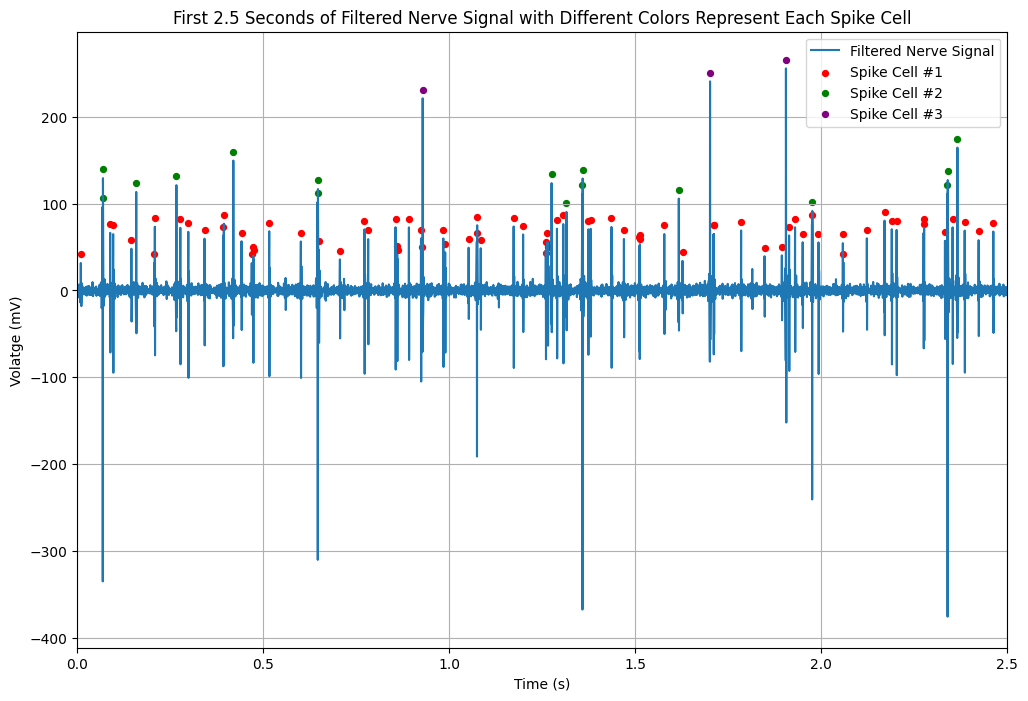

In [283]:
# My code here
Cell_Nums = 3
Spike_Threshold1 = 85
Spike_Threshold2 = 180
# sorted_peak_voltage = np.array(sorted_peak_voltage)

sorted_index1 = np.where(peak_voltage < Spike_Threshold1)[0]
# print(sorted_index1)
spike_indices1 = spike_indices[sorted_index1]
# print(spike_indices1)

sorted_index2 = np.where(np.logical_and(peak_voltage > Spike_Threshold1, peak_voltage < Spike_Threshold2))[0]
# print(sorted_index2)
spike_indices2 = spike_indices[sorted_index2]

sorted_index3 = np.where(peak_voltage > Spike_Threshold2)[0]
# print(sorted_index3)
spike_indices3 = spike_indices[sorted_index3]

sorted_indices = [spike_indices1, spike_indices2, spike_indices3]
# print(sorted_indices[1])

color_lst = ['red','green','purple']
cell_lst = ['Spike Cell #1', 'Spike Cell #2', 'Spike Cell #3']
plt.figure(figsize = (12,8))
plt.plot(nerve_TimeRange2, filtfilt_output,label = 'Filtered Nerve Signal')

for i in range(Cell_Nums):
  iterated_spike_time = nerve_TimeRange2[sorted_indices[i]]
  iterated_peak_voltage = filtfilt_output[sorted_indices[i]]
  plt.scatter(iterated_spike_time, iterated_peak_voltage + 10,s = 18, color = color_lst[i],label = cell_lst[i])

plt.xlabel('Time (s)')
plt.xlim(0,2.5)
plt.ylabel('Volatge (mV)')
plt.title('First 2.5 Seconds of Filtered Nerve Signal with Different Colors Represent Each Spike Cell')
plt.grid(True)
plt.legend()
plt.show()

### 5

Use [``sklearn.cluster.KMeans``](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)$^1$ to fit *k* clusters (where *k* is the number of cells you think the recording is picking up) to the 1D data for each spike.

$^1$Clustering, like $k$-means you are using here, is a form of unsupervised learning.


In [284]:
# My code here
### n_clusters = 3
k_means = KMeans(n_clusters = Cell_Nums, random_state = 0, n_init = 'auto').fit(peak_voltage)

#### 5a

Using the same color order (for increasing spike amplitude) as you did for the thresholds in question 1.4, plot the spike cluster colors as small dots slightly above those you made for question 1.4. The final figure should be a new plot of the nerve voltage and two dots above each spike, the first being your manual label and the second your clustered label, which should mostly be the same color. (4 pts)

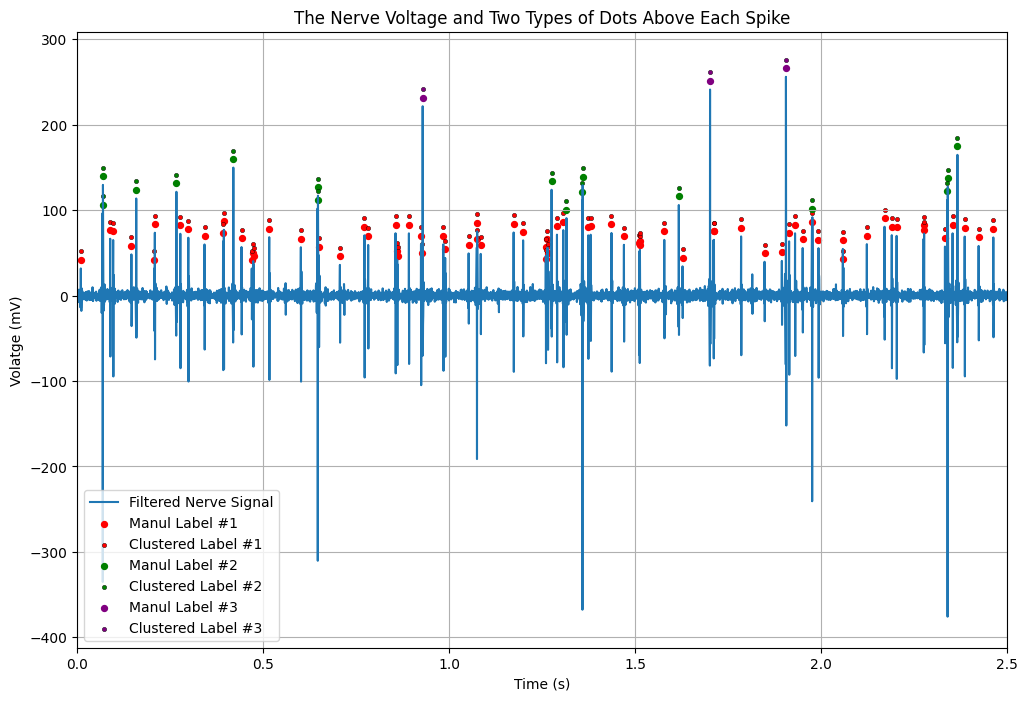

In [285]:
# My code here
k_clusters = k_means.predict(peak_voltage)
# print(k_clusters)
# print(len(np.where(k_clusters == 0)[0])): 26
# print(len(np.where(k_clusters == 1)[0])): 121
# print(len(np.where(k_clusters == 2)[0])): 8

### The number of spikes in the certain cluster is tested to be as same as related manual cell
# print(len(spike_indices1))
# Nums of Spikes in Cluster#1 = 121
cluster1_idx = spike_indices[np.where(k_clusters == 1)[0]]
# print(len(cluster1_idx))

# print(len(spike_indices2))
# Nums of Spikes in Cluster#2 = 26
cluster2_idx = spike_indices[np.where(k_clusters == 0)[0]]
# print(len(cluster2_idx))

# print(len(spike_indices3))
# Nums of Spikes in Cluster#3 = 8
cluster3_idx = spike_indices[np.where(k_clusters == 2)[0]]
# print(len(cluster3_idx))


cluster_indices = [cluster1_idx, cluster2_idx, cluster3_idx]

cell_lst2 = ['Manul Label #1', 'Manul Label #2', 'Manul Label #3']
cluster_lst = ["Clustered Label #1", "Clustered Label #2", "Clustered Label #3"]
plt.figure(figsize = (12,8))
plt.plot(nerve_TimeRange2,filtfilt_output,label = 'Filtered Nerve Signal')

for i in range(Cell_Nums):
  spike_time_cell = nerve_TimeRange2[sorted_indices[i]]
  spike_time_cluster = nerve_TimeRange2[cluster_indices[i]]
  peak_voltage2 = filtfilt_output[sorted_indices[i]]
  peak_cluster = filtfilt_output[cluster_indices[i]]

  plt.scatter(spike_time_cell, peak_voltage2 + 10,s = 18, color = color_lst[i],label = cell_lst2[i])

  ### The Clustered Label on the top of Manual Label is smaller dots in the new plot, I incorporate black edges to clusters' dots to better visualize
  plt.scatter(spike_time_cluster, peak_cluster + 20,s = 10, color = color_lst[i], label = cluster_lst[i], edgecolors='black',linewidths=0.3)

plt.xlabel('Time (s)')
plt.xlim(0,2.5)
plt.ylabel('Volatge (mV)')
plt.title('The Nerve Voltage and Two Types of Dots Above Each Spike')
plt.grid(True)
plt.legend()
plt.show()

#### 5b

Which labeling, (your manual ones or the ones learned by clustering) seems best, or do they both seem just as good? (Again, panning over the entire plot may be helpful.) (2 pts)

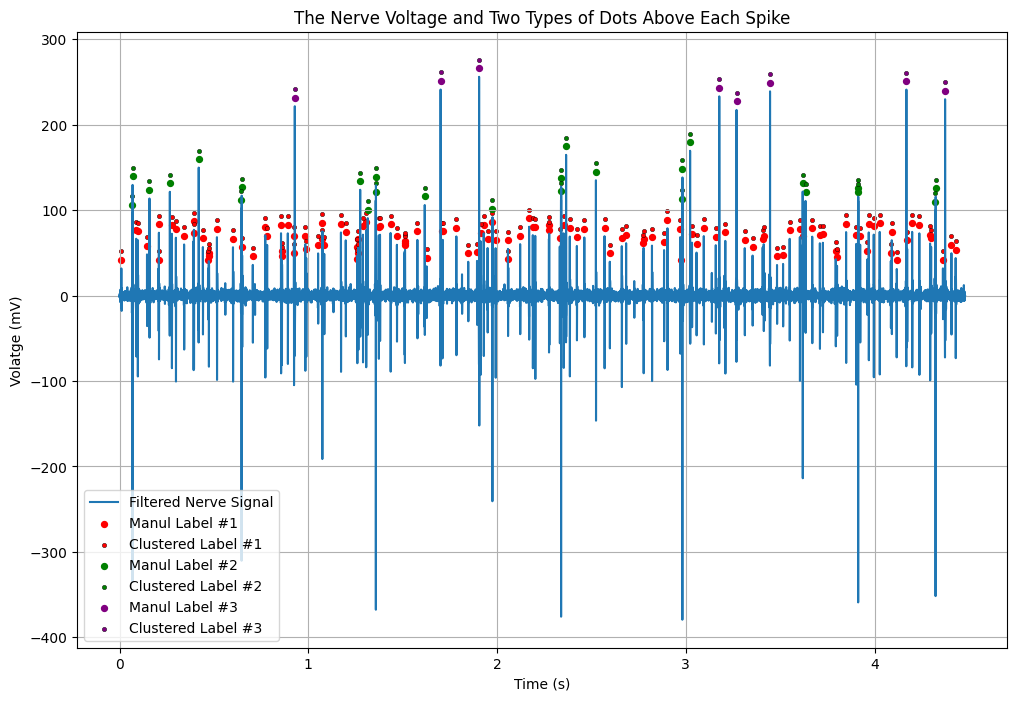

In [286]:
# My code here
### Panning over the entire plot
plt.figure(figsize = (12,8))
plt.plot(nerve_TimeRange2,filtfilt_output,label = 'Filtered Nerve Signal')

for i in range(Cell_Nums):
  spike_time_cell = nerve_TimeRange2[sorted_indices[i]]
  spike_time_cluster = nerve_TimeRange2[cluster_indices[i]]
  peak_voltage2 = filtfilt_output[sorted_indices[i]]
  peak_cluster = filtfilt_output[cluster_indices[i]]

  plt.scatter(spike_time_cell, peak_voltage2 + 10,s = 18, color = color_lst[i],label = cell_lst2[i])

  ### The Clustered Label on the top of Manual Label is smaller dots in the new plot, I incorporate black edges to clusters' dots to better visualize
  plt.scatter(spike_time_cluster, peak_cluster + 20,s = 10, color = color_lst[i], label = cluster_lst[i], edgecolors='black',linewidths=0.3)

plt.xlabel('Time (s)')
# plt.xlim(0,2.5)
plt.ylabel('Volatge (mV)')
plt.title('The Nerve Voltage and Two Types of Dots Above Each Spike')
plt.grid(True)
plt.legend()
plt.show()

**My Answer Here:**

**Manual ones seem to be as good as the ones learned by clustering.**

**[1]** **According to the entire plot, each smaller dot of clustering which is exactly on the top of its related manual one, which proves two methods seem just as good.**

**[2]** **Meanwhile, the number of spikes in the certain cluster is tested to be as same as its related manual cell:**

Number of Spikes in Cluster#1 = 121 = Number of spikes in Cell#1

Number of Spikes in Cluster#2 = 26 = Number of spikes in Cell#2

Number of Spikes in Cluster#3 = 8 = Number of spikes in Cell#3

### 6
In this question,  you will test the hypothesis that the muscle potential responses are really only due to spikes from a subset of the cells you have identified in the previous two questions. First, plot the first 2.5 seconds of the muscle fiber potential and compare it with that of the nerve. Observe the relationship between spikes and the muscle fiber response. (No need to include this plot and observation in your report.) Now, calculate the maximum muscle fiber potential change$^1$ in the 25 ms$^2$ window after each spike (with the assumption that spikes without any/much effect on the muscle fiber potential do not directly innervate it).


$^1$ max voltage - min voltage

$^2$ Note that this 25 ms window is somewhat ad hoc and is just what seems reasonable by eye for this data. It implies no underlying physiological timescale or standard.

In [287]:
# My code here
### Muscle Data: Index[0]
muscle_timeseries = dataset1.get_time_series_details(dataset1_label[0])
print(muscle_timeseries, "\n")
muscle_sample_rate = int(muscle_timeseries.sample_rate)
print("Smpling rate of the muscle:",muscle_sample_rate, "Hz", "\n")

muscle_start_time = muscle_timeseries.start_time
muscle_end_time = muscle_timeseries.end_time

muscle_duration = muscle_timeseries.duration
print("Duration of the muscle:", muscle_duration, "us \n")

### Extract Nerve Data from an extracellular recording from the third nerve (channel nerve)
muscle_data = dataset1.get_data(muscle_start_time, muscle_end_time - muscle_start_time + 1,[0]) * 10**-3 # Convert unit from μV to mV
print("The total number of the muscle units:", len(muscle_data), "\n")
print("Muscle_Data(mV):\n", muscle_data)

None(muscle) spans 4479500.0 usec, range [-76800--64599] in 8960 samples. Starts @1 uUTC, ends @4479501 uUTC with sample rate 2000.0 Hz and voltage conv factor 1.0 

Smpling rate of the muscle: 2000 Hz 

Duration of the muscle: 4479500.0 us 

The total number of the muscle units: 8960 

Muscle_Data(mV):
 [[-72.3]
 [-72.2]
 [-72.5]
 ...
 [-75.7]
 [-75.7]
 [-75.7]]


In [288]:
# My code here
filtfilt_output2 = filtfilt(b, a, muscle_data, axis = 0, padlen = 0)
muscle_duration_sec = muscle_duration * 10**(-6)
Step2 = 1 / muscle_sample_rate
muscle_TimeRange2 = np.arange(0, muscle_duration_sec + Step2 , Step2)

### First, plot the first 2.5 seconds of the muscle fiber potential and compare it with that of the nerve.
### Observe the relationship between spikes and the muscle fiber response.
# plt.figure(figsize=(12, 5))
# plt.plot(muscle_TimeRange2, muscle_data, label='Filtered muscle Signal')
# plt.xlim(0, 2.5)
# plt.grid(True)
# plt.xlabel('Time (s)')
# plt.ylabel('Voltage (mV)')
# plt.title("First 2.5 Seconds of The Filtered Muscle Signal's Potential Response")
# plt.legend()
# plt.show()

In [289]:
# My code here
WinLen = 25 * 10**-3 #25ms = 25 * 10**-3s

### Calculate the maximum muscle fiber potential change in the 25 ms window after each spike
def Calculate_MPC(Muscle_Data, Start_Time):
  start_index = int(Start_Time * muscle_sample_rate)
  end_index = int(start_index + WinLen * muscle_sample_rate)
  Max_Voltage = np.max(Muscle_Data[start_index:end_index])
  Min_Voltage = np.min(Muscle_Data[start_index:end_index])
  MPC = Max_Voltage - Min_Voltage
  return MPC

MPC_lst = []

# print(spike_time)
for i in range(len(spike_time)):
  Iterated_MPC = Calculate_MPC(muscle_data, spike_time[i])
  MPC_lst.append(Iterated_MPC)

print("Entire List of Maximum Muscle Fiber Potential Change (mV):\n", np.array(MPC_lst))
MPC_Arr = np.array(MPC_lst)

Entire List of Maximum Muscle Fiber Potential Change (mV):
 [4.    1.7   1.7   4.8   3.8   5.8   5.8   4.1   4.1   1.2   0.6   3.2
 1.    4.5   4.4   5.1   1.9   2.8   2.8   2.5   0.9   1.    1.3   1.3
 1.3   4.1   4.4   4.1   1.4   1.4   1.4   4.4   5.4   5.4   5.4   3.4
 3.3   0.9   3.2   3.2   3.    3.8   1.    8.801 8.801 9.501 9.601 9.4
 4.2   1.6   2.2   6.5   6.5   2.8   2.    1.2   3.8   0.8   0.8   1.
 4.1   4.3   2.1   3.1   3.1   3.1   0.8   0.9   6.8   6.8   7.2   6.2
 2.9   3.    2.7   1.4   4.3   4.3   0.8   1.1   4.1   3.8   4.2   4.2
 4.8   6.4   6.4   2.8   3.3   1.1   3.2   1.    4.5   3.3   1.6   0.9
 3.3   4.1   4.1   1.2   3.8   1.5   4.2   3.3   1.8   1.9   4.8   2.1
 3.6   1.1   1.3   1.5   3.4   1.1   4.5   1.3   9.201 5.301 3.1   1.1
 3.3   0.8   8.7   8.4   8.4   3.2   1.2   3.6   1.8   4.3   2.5   1.5
 6.6   8.2   8.1   3.    1.7   1.9   2.7   0.8   4.7   4.5   5.9   1.3
 1.1   3.9   1.5   4.4   3.7   6.8   6.8   1.7   2.2   3.8   1.   ]


#### 6a

Using the cell groups you either manually defined or found via *k*-means clustering (just specify which you're using) again with different colors, plot a colored point for each spike where the x-value is the spike amplitude and the y-value is the muscle potential change. (6 pts)

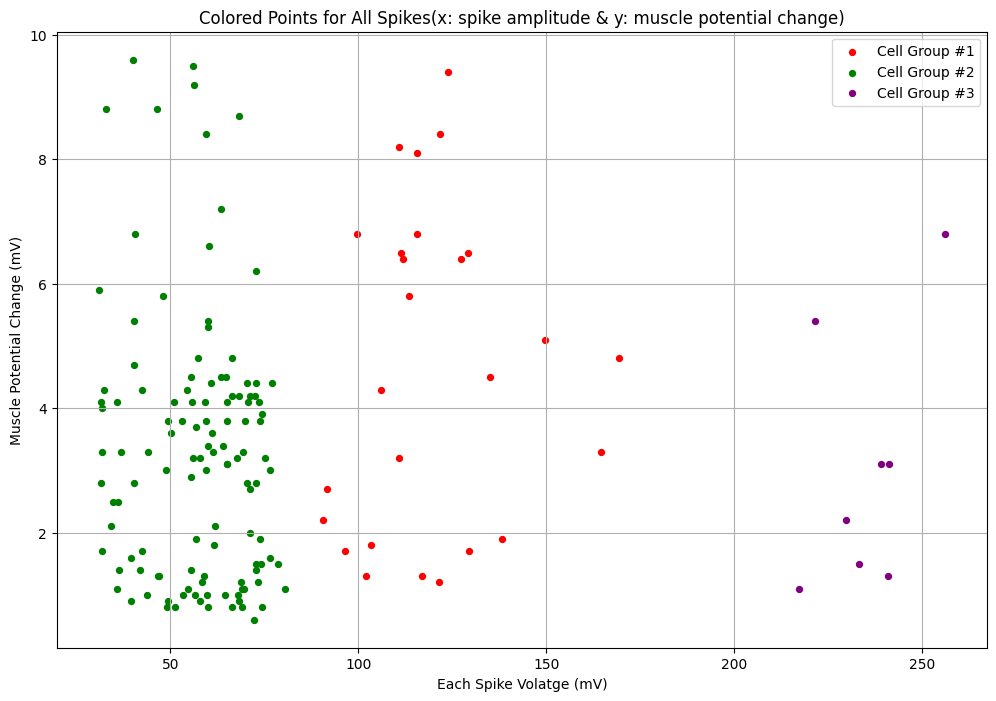

In [290]:
# My code here
### I yse cell groups found via k-keans
Muscle_Index1 = np.where(k_clusters == 0)[0]
Muscle_Index2 = np.where(k_clusters == 1)[0]
Muscle_Index3 = np.where(k_clusters == 2)[0]
Muscle_Indices = [Muscle_Index1, Muscle_Index2, Muscle_Index3]
group_lst = ["Cell Group #1", "Cell Group #2", "Cell Group #3"]

plt.figure(figsize=(12, 8))
for i in range(Cell_Nums):
  # peak_voltage2 = filtfilt_output[sorted_indices[i]]
  peak_cluster2 = peak_voltage[Muscle_Indices[i]]
  Tmp_MPC = MPC_Arr[Muscle_Indices[i]]
  plt.scatter(peak_cluster2, Tmp_MPC,s = 18, color = color_lst[i], label = group_lst[i])

plt.xlabel('Each Spike Volatge (mV)')
plt.ylabel('Muscle Potential Change (mV)')
plt.title('Colored Points for All Spikes(x: spike amplitude & y: muscle potential change)')
plt.grid(True)
plt.legend()
plt.show()

#### 6b
Does this plot support the hypothesis that the muscle fiber responses are only due to a subset of the cells? Explain why or why not. (3 pts)

**My Answer Here:**

**This plot above doesn't support the hypothesis that the muscle fiber responses are only due to a subset of the cells.**

Because I didn't observe a subset of the cells in each Cell Group can accurately classify a cluster of cells with particular Potential Change. In the other words, we still have to use most of the cells to appropriately approximate the muscle fiber responses(potential change of muscle).


## 2. Multivariate Clustering (22 pts)

In this section, you will explore similar methods for spikes sorting and clustering but with a different dataset, the human intracranial data in ``I521_A0006_D002``\, which is a larger dataset of the same recording you saw in ``I521_A0001_D001`` of Homework 1.

In [291]:
with open('/content/Yua_ieeglogin.bin', 'r') as f:
  session = Session('Yuanchz1118', f.read())

# get the specified dataset from IEEG
dataset2 = session.open_dataset('I521_A0006_D002')

dataset2_label = dataset2.get_channel_labels()
print(dataset2_label, "\n")
dataset2_index = dataset2.get_channel_indices(dataset2_label)
print(dataset2_index, "\n")

### multi Data: Index[0]
multi_timeseries = dataset2.get_time_series_details(dataset2_label[0])
print(multi_timeseries, "\n")
multi_sample_rate = int(multi_timeseries.sample_rate)
print("Smpling rate of the multi:", multi_sample_rate, "Hz", "\n")

multi_start_time = multi_timeseries.start_time
multi_end_time = multi_timeseries.end_time

multi_duration = multi_timeseries.duration
print("Duration of the multi:", multi_duration, "us \n")

### Extract Nerve Data from an extracellular recording from the third nerve (channel nerve)
multi_data = dataset2.get_data(multi_start_time, multi_end_time - multi_start_time + 1,[0])
print("The total number of the muscle units:", len(multi_data), "\n")
print("Multi_Data(mV):\n",  multi_data)

['manyUnits'] 

[0] 

None(manyUnits) spans 178844906.0 usec, range [-107280-143850] in 5769180 samples. Starts @1 uUTC, ends @178844907 uUTC with sample rate 32258.0 Hz and voltage conv factor 0.001 

Smpling rate of the multi: 32258 Hz 

Duration of the multi: 178844906.0 us 

The total number of the muscle units: 5769180 

Multi_Data(mV):
 [[-2.12 ]
 [-1.103]
 [ 0.239]
 ...
 [ 2.685]
 [ 2.525]
 [ 3.431]]


### 1

Using a threshold six standard deviations above the mean of the signal, detect the spikes in the signal. In addition, extract the waveform from 1 ms before the peak to 1 ms after it with a peak value in the middle. (You will end up with a matrix where each row corresponds to the number of data points in 2 ms of signal minus 1 data point. Use the closest integer number of data points for the $\pm$1 ms window.)


In [292]:
# My code here
mean_multi_data = np.mean(multi_data)
std_multi_data = np.std(multi_data)
threshold_multi_data = mean_multi_data + 6 * std_multi_data
t_before_peak = 1 * 10**-3
extract_t_range = 2 * 10**-3

### Previous Defined Function in 1.3: Retun the list of Spike Indices
multi_spike_indices = Locate_Spike(multi_data, threshold_multi_data)
# print(multi_spike_indices.shape)
# print(len(multi_spike_indices))
# print(multi_spike_indices)

### the number of data points in 2 ms of signal minus 1 data point
extracted_multi = np.zeros((len(multi_spike_indices), int(np.round(multi_sample_rate * extract_t_range) - 1)))
#print(extracted_multi.shape)
# print(extracted_multi)

for j in range(len(multi_spike_indices)):
  # print(j)
  # print(multi_spike_indices[j])
  # extracted_tmp_lst = []

  multi_spike_tmp = multi_spike_indices[j]
  multi_start_index = multi_spike_tmp - int(np.round(multi_sample_rate * t_before_peak))
  multi_end_index = multi_spike_tmp + int(np.round(multi_sample_rate * t_before_peak))
  # extracted_tmp = multi_data[multi_start_index:multi_end_index].reshape(-1)
  # print(extracted_tmp.shape)

  ### Find the index of the highest peak within the window
  peak_index = multi_start_index + np.argmax(multi_data[multi_start_index:multi_end_index])

  ### Extract the waveform centered around the highest peak
  extracted_tmp = multi_data[peak_index - int(np.round(multi_sample_rate * t_before_peak)):
  peak_index + int(np.round(multi_sample_rate * t_before_peak))].reshape(-1)

  extracted_multi[j] = extracted_tmp

print("Middle Peak Matrix (μV):\n", extracted_multi)
print("\n\nShape of Middle Peak Matrix:", extracted_multi.shape)

Middle Peak Matrix (μV):
 [[-11.484 -13.817 -13.84  ... -32.637 -34.692 -34.413]
 [-13.149 -15.02  -16.842 ... -19.742 -19.125 -17.237]
 [ -9.865 -10.171  -9.022 ... -31.214 -32.79  -32.676]
 ...
 [-14.938 -15.707 -15.582 ... -33.59  -31.609 -28.337]
 [-11.39  -11.649 -10.08  ...  -3.327  -6.627 -11.89 ]
 [-15.835 -15.517 -15.397 ... -18.01  -17.237 -16.314]]


Shape of Middle Peak Matrix: (308, 64)


#### 1a

Plot the waveforms of all the spikes overlaid on each other in the same color. (4 pts)

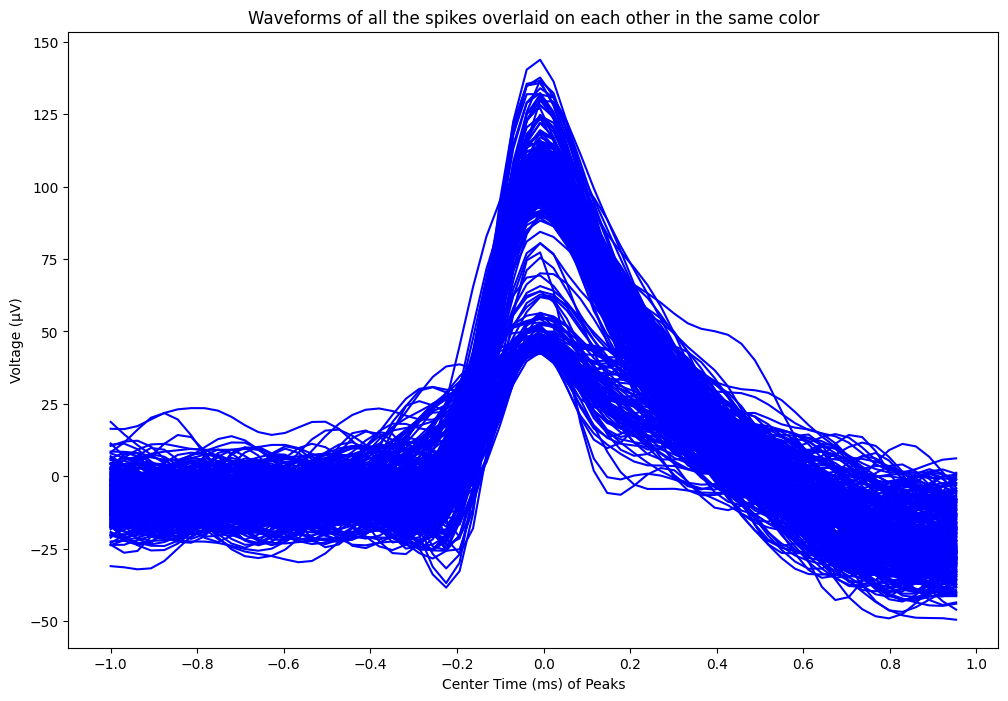

In [293]:
# My code here
# print(len(multi_spike_indices))
# print(extracted_multi.shape)

Step3 = 10**3 / multi_sample_rate
center_time = np.arange(-1, 1 - Step3, Step3)

plt.figure(figsize = (12,8))
plt.title('Waveforms of all the spikes overlaid on each other in the same color')

for i in range(len(multi_spike_indices)):
  plt.plot(center_time, extracted_multi[i], color = 'blue')

plt.xlabel('Center Time (ms) of Peaks')
plt.xticks(np.arange(-1,1.2,0.2))
plt.ylabel('Voltage (μV)')
plt.show()

#### 1b

Does it looks like there is more than one type of spike? (1 pt)

**My Answer Here:**

**Yes, waveforms of all the spikes overlaid on each other show that there is more than one tyoe of spike.**

Although all spikes seem to converge to a central peak, but too many spikes with same colors in one plot would impact observation. My conclusion is based on comparing all spikes in the Middle Peak Matrix (μV).

### 2

For each spike, represent the waveform by its  principal components. Use [``sklearn.decomposition.PCA``](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). Intuitively, principal component analysis (PCA) finds the coordinate system that most reduces the variability in your data.


#### 2a
Run principal component analysis on all the spike waveforms and represent your data with the top two principal components. Make a scatterplot of your data in this principal component (PC) space. (3 pts)


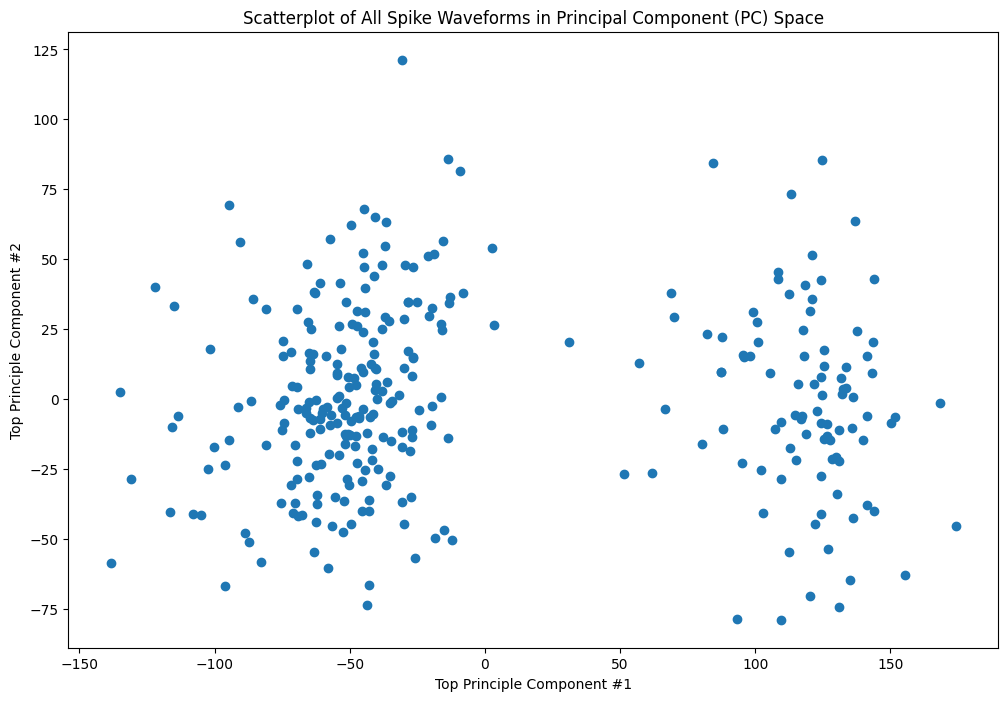

In [294]:
# My code here
### top two principal components
pca_wave = PCA(n_components=2)
PC_Converted = pca_wave.fit_transform(extracted_multi)
# print(PC_Converted)
# print(len(PC_Converted))

plt.figure(figsize = (12,8))
plt.title('Scatterplot of All Spike Waveforms in Principal Component (PC) Space')
plt.xlabel('Top Principle Component #1')
plt.ylabel('Top Principle Component #2')
plt.scatter(PC_Converted[:,0], PC_Converted[:,1])
plt.show()

#### 2b
Each PC also has an associated eigenvalue, representing the amount of variance explained by that PC. This the second output of ``sklearn.decomposition.PCA``. Plot the  principal component vs the total (cumulative) percent variance explained for the 64 components. What is the percent variance explained if you include the top two principal components? (3 pts)

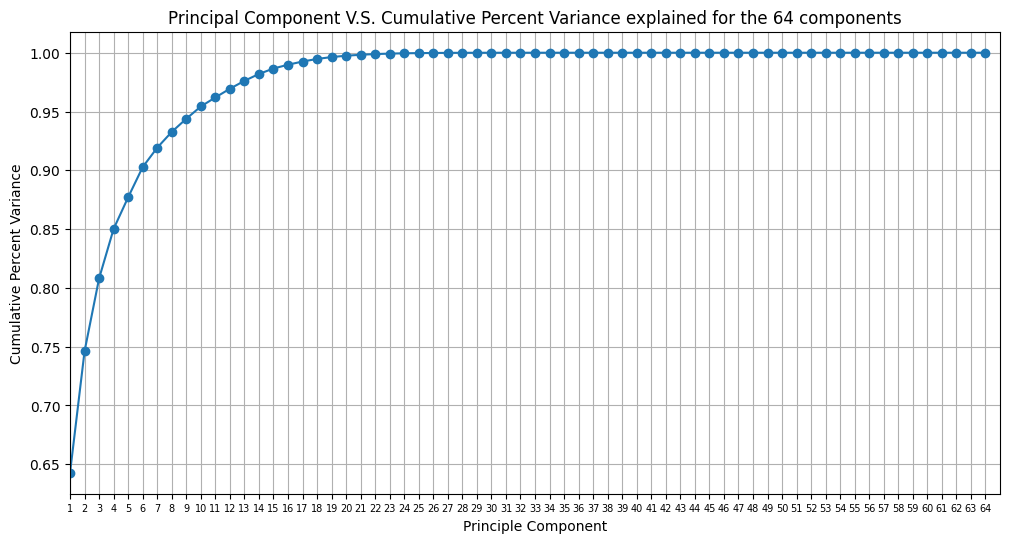



The percent variance of the 1st top PC is:  0.6428303575225037
The percent variance of the 2nd top PC is:  0.1032936151144843


In [295]:
# My code here
cumulative_p_var = PCA().fit(extracted_multi).explained_variance_ratio_.cumsum()
# print(cumulative_p_var)
# print(len(cumulative_p_var))
nums_cumulative = len(cumulative_p_var) + 1

plt.figure(figsize=(12,6))
plt.title('Principal Component V.S. Cumulative Percent Variance explained for the 64 components')
plt.plot(np.arange(1,nums_cumulative),cumulative_p_var,'-o', label = "Current c")
plt.xlabel('Principle Component')
plt.xticks(np.arange(1,nums_cumulative),size = 7)
plt.xlim(1,nums_cumulative)
plt.ylabel('Cumulative Percent Variance')
plt.grid(True)
plt.show()

percent_var = PCA().fit(extracted_multi).explained_variance_ratio_
print('\n\nThe percent variance of the 1st top PC is: ', percent_var[0])
print('The percent variance of the 2nd top PC is: ', percent_var[1])

**My Answer Here:**

The percent variance of the **1st Top PC** is:  **0.6428303575225037**

The percent variance of the **2nd Top PC** is:  **0.1032936151144843**

#### 2c
Does it look like there is more than one cluster of spikes? (1 pt)


**My Answer Here:**

**Yes, it looks like there is more than one cluster (2 Clusters) of spikes.**



### 3
Use the same ``kmeans`` function as you used before to cluster the spikes based on these two (normalized) features (the waveforms represented by the top two PCs). Make a plot similar to that in 2.2a but now coloring the two clusters red and green. (3 pts)

<Figure size 1200x500 with 0 Axes>

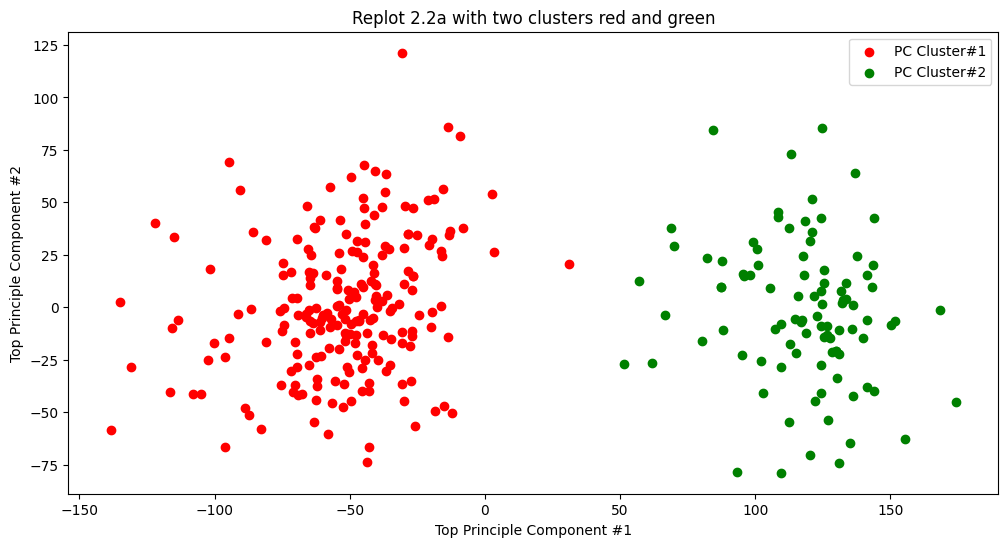

In [296]:
# My code here
PC_Cluster = KMeans(n_clusters=2,random_state=0, n_init='auto').fit(PC_Converted).predict(PC_Converted)
plt.figure(figsize=(12,5))
pc_color_set = ['red','green']
pc_label_set = ["PC Cluster#1", "PC Cluster#2"]

plt.figure(figsize=(12,6))
plt.title('Replot 2.2a with two clusters red and green')

for i in range(2):
  tmp_wave = PC_Converted[np.where(PC_Cluster == i)[0]]
  plt.scatter(tmp_wave[:,0], tmp_wave[:,1], color = pc_color_set[i], label = pc_label_set[i])

plt.xlabel('Top Principle Component #1')
plt.ylabel('Top Principle Component #2')
plt.legend()
plt.show()

### 4
Make a plot similar to 2.1 but now coloring the traces red and green according to which cluster they are in. Overlay the mean of the waveforms in each cluster with a thick black line (set the parameter ``linewidth=4``). (3 pts)

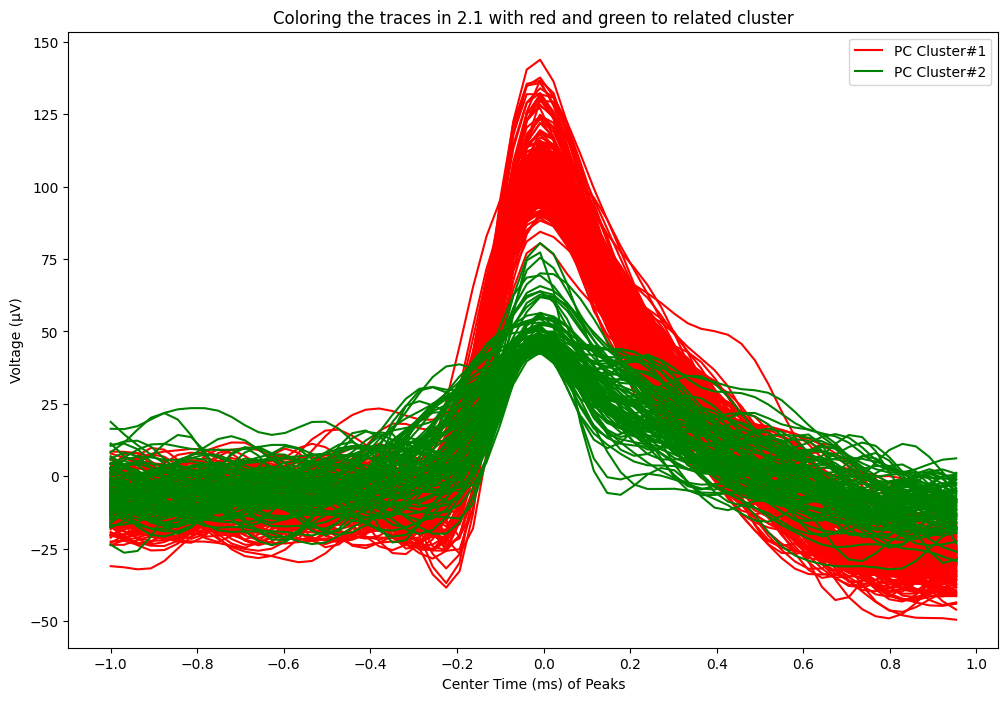

In [297]:
# My code here
Step3 = 10**3 / multi_sample_rate
center_time = np.arange(-1, 1 - Step3, Step3)

PC_Index1 = np.where(PC_Cluster == 0)[0]
# print(PC_Index1)
# print(len(PC_Index1))

PC_Index2 = np.where(PC_Cluster == 1)[0]
# print('\n', PC_Index2)
# print(len(PC_Index2))

PC_Indices = [PC_Index1, PC_Index2]
# print(PC_Indices)
# print(len(PC_Indices))

plt.figure(figsize = (12,8))
plt.title('Coloring the traces in 2.1 with red and green to related cluster')

for i in range(2):
  for j in PC_Indices[i]:
    tmp_multi = extracted_multi[j]
    plt.plot(center_time, tmp_multi, color = pc_color_set[i])

for k, label in enumerate(pc_label_set):
    plt.plot([], [], color = pc_color_set[k], label = label)

plt.xlabel('Center Time (ms) of Peaks')
plt.xticks(np.arange(-1,1.2,0.2))
plt.ylabel('Voltage (μV)')
plt.legend()
plt.show()

### 5
What is a disadvantage of using principal component analysis (PCA)? (1 pts)

**My Answer Here:**

**Principal component analysis (PCA) has the disadvantage of occasionally producing components that are harder to understand, mainly when working with high-dimensional data.**

Even while PCA significantly reduces dimensionality and captures variation, it might not be easy to describe the underlying structure of the data since the components produced may not have apparent meanings or interpretations. Furthermore, PCA assumes that variables have linear connections with one another, which may only sometimes be the case in real-world datasets.

**In general, the disadvantage of Principal component analysis (PCA) is that it might result in information loss or erroneous data representation.**

### 6
What are some dangers of using the clustering techniques in this homework? (List 3) (3 pts)


**My Answer Here:**

**[1]** **Unsupervised Nature:** By using ground truth labels to group data based on similarities, clustering algorithms risk misinterpreting or making false assumptions about the data's real structure.

**[2]** **Sensitivity to Parameters:** If a clustering algorithm's parameter (such as the number of clusters or distance metrics) is tuned wrong, it can significantly impact the findings and interpretation.

**[3]** **Curse of Dimensionality:** High-dimensional data makes clustering algorithms more difficult because of increased computing complexity and sparsity, which can result in incorrect clustering or higher computational load.

### 7 (Extra Credit)



#### 7a
Similar to PCA you used in Section 2, there are other types of dimensionality reduction methods avaliable. Do some research to identify other methods, and then replicate Sections 2a, 3 and 4 using one of the method you found. Hint: see [`sklearn.manifold.TSNE`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) and [`umap_learn`](https://umap-learn.readthedocs.io/en/latest/) (4 pts)

**Reference:**

https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

**My Answer Here:**

**I choose to use t-SNE tool to convert similarities in high-dimensional data in 'I521_A0006_D002' to better reduce dimensionality, and replicate processes in Sections 2a, 3 and 4 and revisualize related plots.**

In [298]:
# My code here
### I choose the method of sklearn.manifold.TSNE
from sklearn.manifold import TSNE


**Replicate Sections 2.2a using TSNE:**

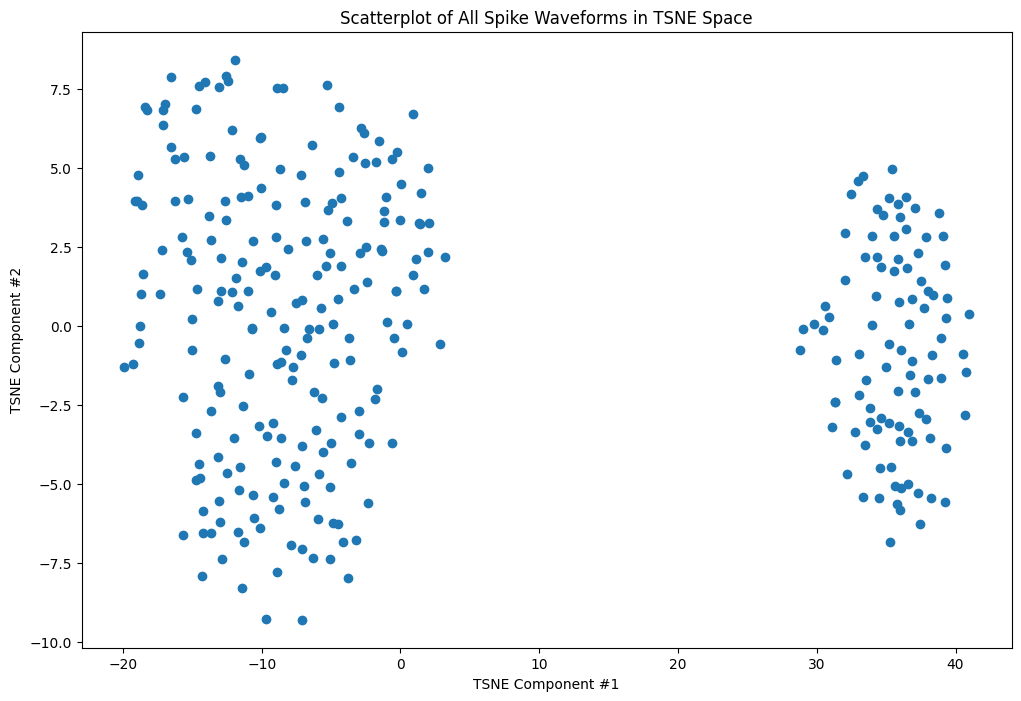

In [299]:
# My code here

### Replicate Sections 2a using TSNE

# Initialize t-SNE object
tsne = TSNE(n_components=2, perplexity = 30, method = 'barnes_hut')

# Fit and convert the TSNE Data
TSNE_Converted = tsne.fit_transform(extracted_multi)

# Plot the transformed data points
plt.figure(figsize=(12, 8))
plt.scatter(TSNE_Converted[:, 0], TSNE_Converted[:, 1])
plt.title('Scatterplot of All Spike Waveforms in TSNE Space')
plt.xlabel('TSNE Component #1')
plt.ylabel('TSNE Component #2')
plt.show()

**Replicate Sections 3 using TSNE:**

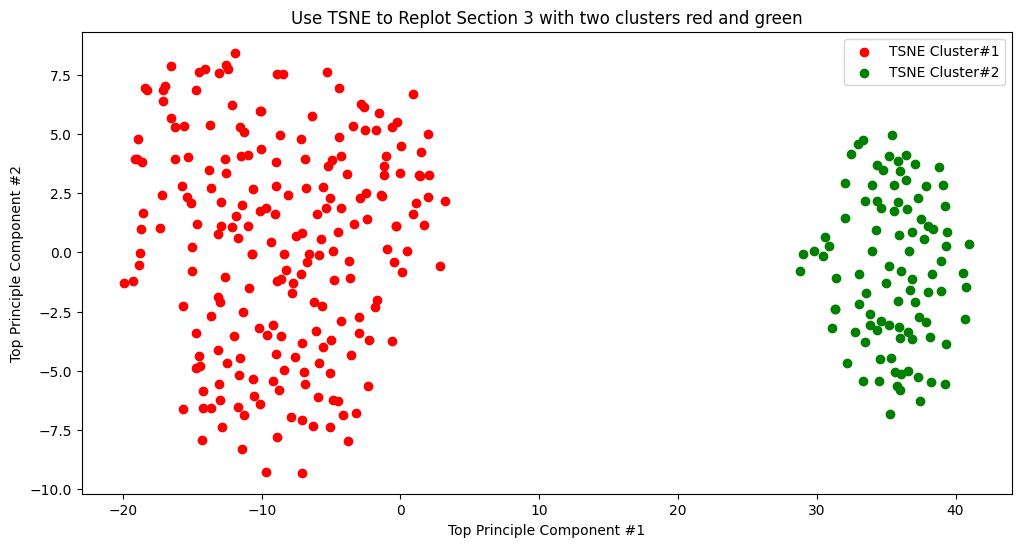

In [300]:
# My code here
TSNE_Cluster = KMeans(n_clusters=2, random_state=0, n_init='auto').fit(TSNE_Converted).predict(TSNE_Converted)
tsne_color_set = ['red','green']
tsne_label_set = ["TSNE Cluster#1", "TSNE Cluster#2"]

plt.figure(figsize=(12,6))
plt.title('Use TSNE to Replot Section 3 with two clusters red and green')

for i in range(2):
  tmp_wave = TSNE_Converted[np.where(TSNE_Cluster == i)[0]]
  plt.scatter(tmp_wave[:,0], tmp_wave[:,1], c = tsne_color_set[i], label = tsne_label_set[i])

plt.xlabel('Top Principle Component #1')
plt.ylabel('Top Principle Component #2')
plt.legend()
plt.show()

**Replicate Sections 4 using TSNE:**

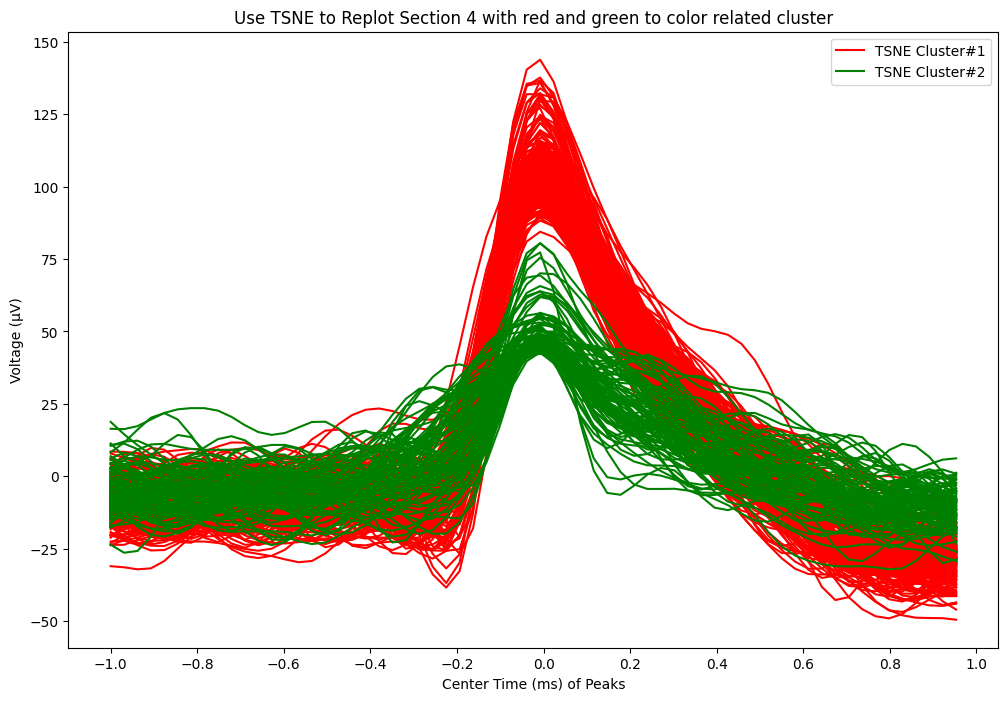

In [301]:
# My code here
Step3 = 10**3 / multi_sample_rate
center_time = np.arange(-1, 1 - Step3, Step3)

TSNE_Index1 = np.where(TSNE_Cluster == 0)[0]
# print(PC_Index1)
# print(len(PC_Index1))

TSNE_Index2 = np.where(TSNE_Cluster == 1)[0]
# print('\n', PC_Index2)
# print(len(PC_Index2))

TSNE_Indices = [TSNE_Index1, TSNE_Index2]
# print(PC_Indices)
# print(len(PC_Indices))

plt.figure(figsize = (12,8))
plt.title('Use TSNE to Replot Section 4 with red and green to color related cluster')

for i in range(2):
  for j in TSNE_Indices[i]:
    tmp_multi2 = extracted_multi[j]
    plt.plot(center_time, tmp_multi2, color = tsne_color_set[i])

for k, label in enumerate(tsne_label_set):
    plt.plot([], [], color = tsne_color_set[k], label = label)

plt.xlabel('Center Time (ms) of Peaks')
plt.xticks(np.arange(-1,1.2,0.2))
plt.ylabel('Voltage (μV)')
plt.legend()
plt.show()

#### 7b
Compare to PCA, state one advantage and one disadvantage for the method you choose.(2 pts)

**My Answer Here:**

**[1]** **One Advantage for the TSNE Compared to PCA:**

**Preservation of Local Structures:** t-SNE may frequently uncover complex associations between neighboring data points in the original high-dimensional space **since t-SNE maintains local structures better than PCA.** Because of this, it's beneficial for analyzing and displaying considerable, complicated information where local interactions are crucial.

**[2]** **One Disadvantage for the TSNE Compared to PCA:**

**Computational Complexity:** **t-SNE is computationally more expensive than PCA for big datasets in particular.** T-SNE may not be as feasible for massive datasets due to its time-consuming optimization procedure, which seeks to reduce the divergence between the original and converted data distributions. Furthermore, the features and parameter choices of the dataset affect the computational cost of t-SNE.**That's why the tutorial of t-SNE suggests reducing dimensionality with PCA for dense data or Truncated SVD for sparse data if the number of features is very high.**